# vanilla VAE

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

class VAE(nn.Module):
    def __init__(self, input_dim=784, hidden_dim=400, latent_dim=20):
        super(VAE, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU()
        )
        
        # Mean and variance layers
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_var = nn.Linear(hidden_dim, latent_dim)
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()
        )
        
    def encode(self, x):
        h = self.encoder(x)
        return self.fc_mu(h), self.fc_var(h)
    
    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def decode(self, z):
        return self.decoder(z)
    
    def forward(self, x):
        mu, log_var = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, log_var)
        return self.decode(z), mu, log_var

def loss_function(recon_x, x, mu, log_var):
    # Reconstruction loss (binary cross entropy)
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    
    # KL divergence loss
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    
    return BCE + KLD

def train_vae(model, train_loader, optimizer, device, epoch):
    model.train()
    train_loss = 0
    
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        
        recon_batch, mu, log_var = model(data)
        loss = loss_function(recon_batch, data, mu, log_var)
        
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        
        if batch_idx % 100 == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} '
                  f'({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item() / len(data):.6f}')
    
    avg_loss = train_loss / len(train_loader.dataset)
    print(f'====> Epoch: {epoch} Average loss: {avg_loss:.4f}')
    return avg_loss

def visualize_reconstruction(model, data_loader, device, num_images=8):
    model.eval()
    with torch.no_grad():
        data = next(iter(data_loader))[0][:num_images].to(device)
        recon_batch, _, _ = model(data)
        
        # Plot original and reconstructed images
        fig, axes = plt.subplots(2, num_images, figsize=(2*num_images, 4))
        
        for i in range(num_images):
            # Original images
            axes[0, i].imshow(data[i].cpu().numpy().reshape(28, 28), cmap='gray')
            axes[0, i].axis('off')
            if i == 0:
                axes[0, i].set_title('Original')
                
            # Reconstructed images
            axes[1, i].imshow(recon_batch[i].cpu().numpy().reshape(28, 28), cmap='gray')
            axes[1, i].axis('off')
            if i == 0:
                axes[1, i].set_title('Reconstructed')
        
        plt.tight_layout()
        return fig

# Training setup and example usage
def main():
    # Hyperparameters
    batch_size = 128
    epochs = 50
    learning_rate = 1e-3
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Load MNIST dataset
    transform = transforms.Compose([
        transforms.ToTensor()
    ])
    
    train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    
    # Initialize model, optimizer
    model = VAE().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    # Training loop
    for epoch in range(1, epochs + 1):
        loss = train_vae(model, train_loader, optimizer, device, epoch)
        
        # Visualize reconstructions every 10 epochs
        if epoch % 10 == 0:
            fig = visualize_reconstruction(model, train_loader, device)
            plt.close(fig)  # Close the figure to free memory
    
    return model

if __name__ == "__main__":
    model = main()

/home/flaccagora/.miniconda3/envs/robogym/lib/python3.11/site-packages/torch/cuda/__init__.py:129: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


Failed to download (trying next):
<urlopen error [Errno 110] Connection timed out>



100%|██████████| 9.91M/9.91M [00:03<00:00, 2.49MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [Errno 110] Connection timed out>



100%|██████████| 28.9k/28.9k [00:00<00:00, 231kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [Errno 110] Connection timed out>



100%|██████████| 1.65M/1.65M [00:01<00:00, 1.03MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [Errno 110] Connection timed out>



100%|██████████| 4.54k/4.54k [00:00<00:00, 965kB/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Train Epoch: 1 [0/60000 (0%)]	Loss: 543.151550
Train Epoch: 1 [12800/60000 (21%)]	Loss: 195.276123
Train Epoch: 1 [25600/60000 (43%)]	Loss: 185.517242
Train Epoch: 1 [38400/60000 (64%)]	Loss: 157.039719
Train Epoch: 1 [51200/60000 (85%)]	Loss: 148.709320
====> Epoch: 1 Average loss: 179.0280
Train Epoch: 2 [0/60000 (0%)]	Loss: 142.408478
Train Epoch: 2 [12800/60000 (21%)]	Loss: 135.317963
Train Epoch: 2 [25600/60000 (43%)]	Loss: 129.506378
Train Epoch: 2 [38400/60000 (64%)]	Loss: 129.188721
Train Epoch: 2 [51200/60000 (85%)]	Loss: 120.472305
====> Epoch: 2 Average loss: 129.2238
Train Epoch: 3 [0/60000 (0%)]	Loss: 123.894730
Train Epoch: 3 [12800/60000 (21%)]	Loss: 115.857483
Train Epoch: 3 [25600/60000 (43%)]	Loss: 117.045166
Train Epoch: 3 [38400/60000 (64%)]	Loss: 122.405983
Train Epoch: 3 [51200/60000 (85%)]	Loss: 114.222366
====> Epoch: 3 Average loss: 117.7437
Train Epoch: 4 [0/60000 (0%)]	Loss: 112.811218

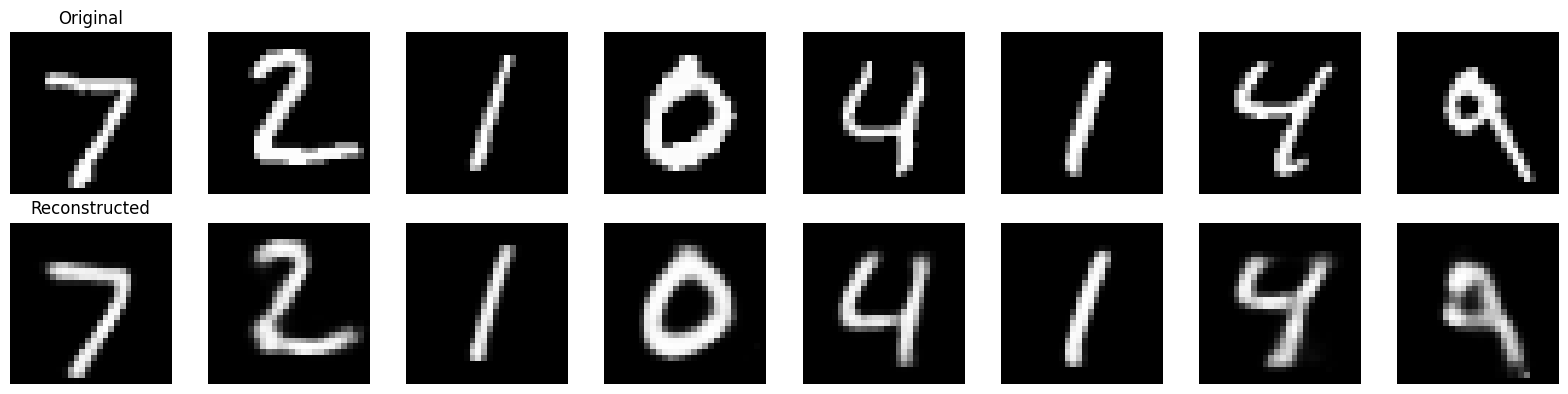

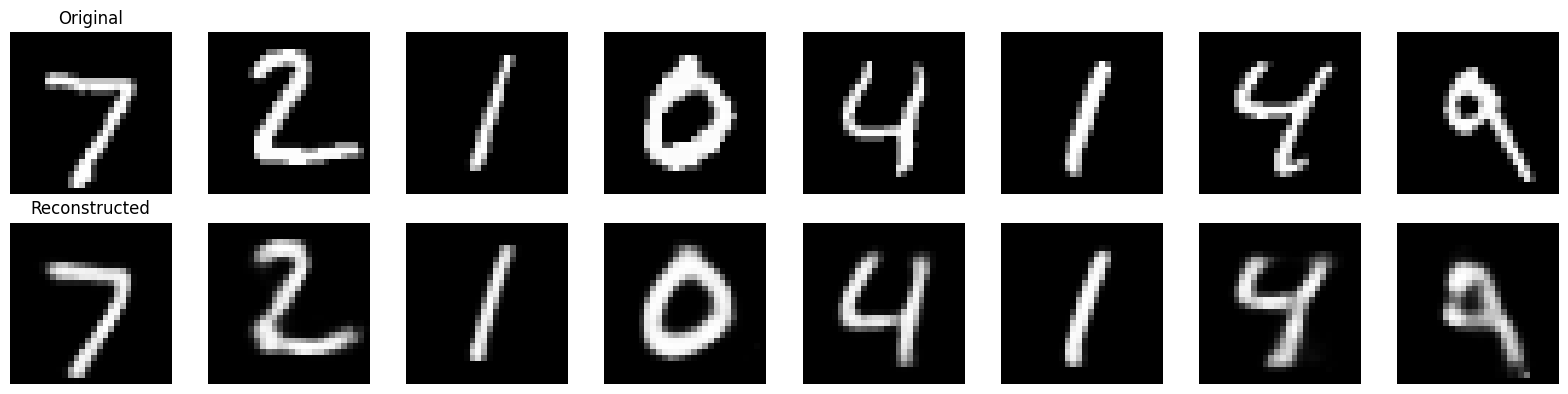

In [3]:
# Load MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor()
])

test_dataset = datasets.MNIST('./data', train=False, download=True, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

visualize_reconstruction(model, test_loader, 'cpu')

In [81]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

class ConditionalVAE(nn.Module):
    def __init__(self, input_dim=784, hidden_dim=400, latent_dim=20, condition_dim=10):
        super(ConditionalVAE, self).__init__()
        
        self.condition_dim = condition_dim
        self.input_with_condition = input_dim + condition_dim
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(self.input_with_condition, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU()
        )
        
        # Mean and variance layers
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_var = nn.Linear(hidden_dim, latent_dim)
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim + condition_dim, hidden_dim),  # Note: decoder input includes condition
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()
        )
        
    def encode(self, x, c):
        # Concatenate input and condition
        x_c = torch.cat([x, c], dim=1)
        h = self.encoder(x_c)
        return self.fc_mu(h), self.fc_var(h)
    
    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def decode(self, z, c):
        # Concatenate latent vector and condition
        z_c = torch.cat([z, c], dim=1)
        return self.decoder(z_c)
    
    def forward(self, x, c):
        mu, log_var = self.encode(x.view(-1, 784), c)
        z = self.reparameterize(mu, log_var)
        return self.decode(z, c), mu, log_var

def loss_function(recon_x, x, mu, log_var):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return BCE + KLD

def train_conditional_vae(model, train_loader, optimizer, device, epoch):
    model.train()
    train_loss = 0
    
    for batch_idx, (data, labels) in enumerate(train_loader):
        data = data.to(device)
        
        # Convert labels to one-hot encoding
        c = F.one_hot(labels, num_classes=model.condition_dim).float().to(device)
        
        optimizer.zero_grad()
        recon_batch, mu, log_var = model(data, c)
        loss = loss_function(recon_batch, data, mu, log_var)
        
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        
        if batch_idx % 100 == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} '
                  f'({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item() / len(data):.6f}')
    
    avg_loss = train_loss / len(train_loader.dataset)
    print(f'====> Epoch: {epoch} Average loss: {avg_loss:.4f}')
    return avg_loss

def visualize_conditional_reconstruction(model, data_loader, device, target_label=None, num_images=8):
    model.eval()
    with torch.no_grad():
        # Get a batch of images
        for data, labels in data_loader:
            if target_label is not None:
                # Filter images of target label
                mask = labels == target_label
                if mask.sum() >= num_images:
                    data = data[mask][:num_images]
                    labels = labels[mask][:num_images]
                    break
            else:
                data = data[:num_images]
                labels = labels[:num_images]
                break
        
        data = data.to(device)
        c = F.one_hot(labels, num_classes=model.condition_dim).float().to(device)
        
        # Get reconstructions
        recon_batch, _, _ = model(data, c)
        
        # Plot original and reconstructed images
        fig, axes = plt.subplots(2, num_images, figsize=(2*num_images, 4))
        
        for i in range(num_images):
            # Original images
            axes[0, i].imshow(data[i].cpu().numpy().reshape(28, 28), cmap='gray')
            axes[0, i].axis('off')
            if i == 0:
                axes[0, i].set_title(f'Original (Label: {labels[i].item()})')
            
            # Reconstructed images
            axes[1, i].imshow(recon_batch[i].cpu().numpy().reshape(28, 28), cmap='gray')
            axes[1, i].axis('off')
            if i == 0:
                axes[1, i].set_title('Reconstructed')
        
        plt.tight_layout()
        return fig

def generate_conditioned_samples(model, device, condition, num_samples=8):
    model.eval()
    with torch.no_grad():
        # Create one-hot encoded condition
        c = F.one_hot(torch.tensor([condition] * num_samples), 
                     num_classes=model.condition_dim).float().to(device)
        
        # Sample from latent space
        z = torch.randn(num_samples, model.fc_mu.out_features).to(device)
        
        # Generate samples
        samples = model.decode(z, c)
        
        # Visualize
        fig, axes = plt.subplots(1, num_samples, figsize=(2*num_samples, 2))
        for i in range(num_samples):
            axes[i].imshow(samples[i].cpu().numpy().reshape(28, 28), cmap='gray')
            axes[i].axis('off')
            if i == 0:
                axes[i].set_title(f'Generated (Label: {condition})')
        
        plt.tight_layout()
        return fig

def main():
    # Hyperparameters
    batch_size = 128
    epochs = 5
    learning_rate = 1e-3
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Load MNIST dataset
    transform = transforms.Compose([
        transforms.ToTensor()
    ])
    
    train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    
    # Initialize model, optimizer
    model = ConditionalVAE(condition_dim=10).to(device)  # 10 classes for MNIST
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    # Training loop
    for epoch in range(1, epochs + 1):
        loss = train_conditional_vae(model, train_loader, optimizer, device, epoch)
        
        # Visualize reconstructions every 10 epochs
        if epoch % 10 == 0:
            # Visualize general reconstructions
            fig1 = visualize_conditional_reconstruction(model, train_loader, device)
            plt.close(fig1)
            
            # Visualize generated samples for a specific digit
            fig2 = generate_conditioned_samples(model, device, condition=7)  # Generate digit 7
            plt.close(fig2)
    
    return model

if __name__ == "__main__":
    model = main()

Train Epoch: 1 [0/60000 (0%)]	Loss: 543.504517
Train Epoch: 1 [12800/60000 (21%)]	Loss: 198.536484
Train Epoch: 1 [25600/60000 (43%)]	Loss: 155.062271
Train Epoch: 1 [38400/60000 (64%)]	Loss: 145.275208
Train Epoch: 1 [51200/60000 (85%)]	Loss: 142.151550
====> Epoch: 1 Average loss: 167.7229
Train Epoch: 2 [0/60000 (0%)]	Loss: 129.791229
Train Epoch: 2 [12800/60000 (21%)]	Loss: 125.729263
Train Epoch: 2 [25600/60000 (43%)]	Loss: 123.110619
Train Epoch: 2 [38400/60000 (64%)]	Loss: 120.193649
Train Epoch: 2 [51200/60000 (85%)]	Loss: 117.099136
====> Epoch: 2 Average loss: 123.0143
Train Epoch: 3 [0/60000 (0%)]	Loss: 112.631104
Train Epoch: 3 [12800/60000 (21%)]	Loss: 115.049080
Train Epoch: 3 [25600/60000 (43%)]	Loss: 117.202835
Train Epoch: 3 [38400/60000 (64%)]	Loss: 116.039612
Train Epoch: 3 [51200/60000 (85%)]	Loss: 110.768692
====> Epoch: 3 Average loss: 113.7051
Train Epoch: 4 [0/60000 (0%)]	Loss: 106.070862
Train Epoch: 4 [12800/60000 (21%)]	Loss: 115.185242
Train Epoch: 4 [25600/

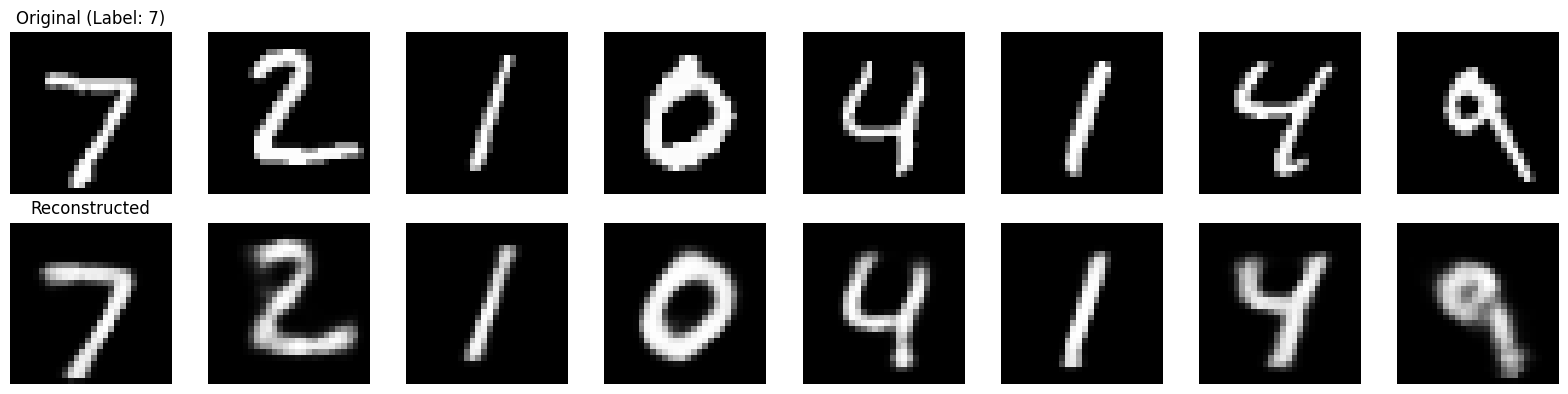

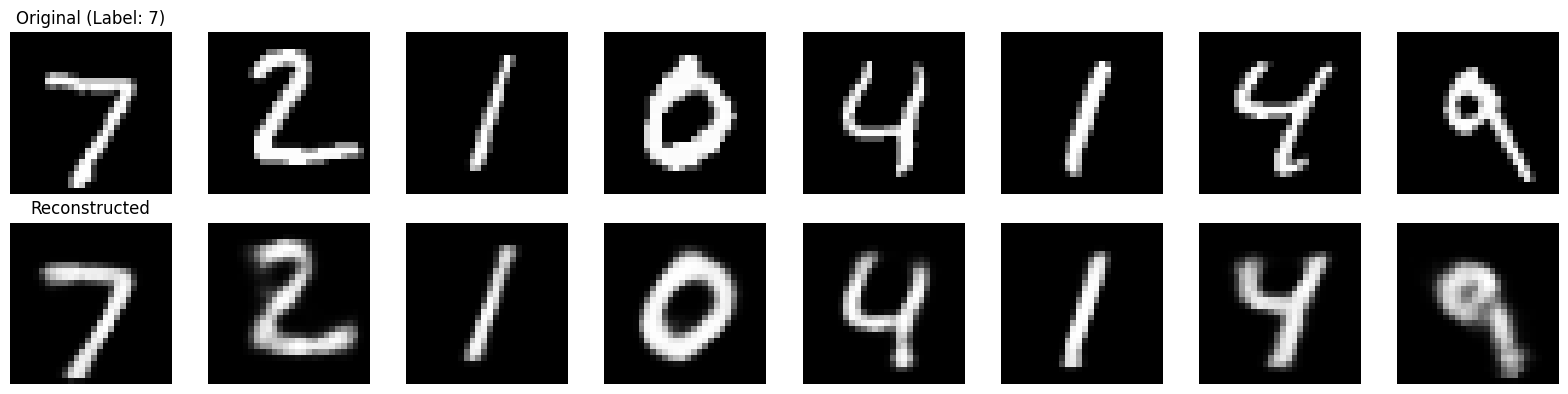

In [82]:
# Load MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor()
])

test_dataset = datasets.MNIST('./data', train=False, download=True, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

visualize_conditional_reconstruction(model, test_loader, 'cpu', target_label=None, num_images=8)

In [ ]:
# Load MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor()
])

test_dataset = datasets.MNIST('./data', train=False, download=True, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

visualize_reconstruction(model, test_loader, 'cpu')

# Conv Autoencoder


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

class ConditionalVAE(nn.Module):
    def __init__(self, input_dim=784, hidden_dim=400, latent_dim=20, condition_dim=10):
        super(ConditionalVAE, self).__init__()
        
        self.condition_dim = condition_dim
        self.input_with_condition = input_dim + condition_dim
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(self.input_with_condition, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU()
        )
        
        # Mean and variance layers
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_var = nn.Linear(hidden_dim, latent_dim)
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim + condition_dim, hidden_dim),  # Note: decoder input includes condition
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()
        )
        
    def encode(self, x, c):
        # Concatenate input and condition
        x_c = torch.cat([x, c], dim=1)
        h = self.encoder(x_c)
        return self.fc_mu(h), self.fc_var(h)
    
    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def decode(self, z, c):
        # Concatenate latent vector and condition
        z_c = torch.cat([z, c], dim=1)
        return self.decoder(z_c)
    
    def forward(self, x, c):
        mu, log_var = self.encode(x.view(-1, 784), c)
        z = self.reparameterize(mu, log_var)
        return self.decode(z, c), mu, log_var

def loss_function(recon_x, x, mu, log_var):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return BCE + KLD

def train_conditional_vae(model, train_loader, optimizer, device, epoch):
    model.train()
    train_loss = 0
    
    for batch_idx, (data, labels) in enumerate(train_loader):
        data = data.to(device)
        
        # Convert labels to one-hot encoding
        c = F.one_hot(labels, num_classes=model.condition_dim).float().to(device)
        
        optimizer.zero_grad()
        recon_batch, mu, log_var = model(data, c)
        loss = loss_function(recon_batch, data, mu, log_var)
        
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        
        if batch_idx % 100 == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} '
                  f'({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item() / len(data):.6f}')
    
    avg_loss = train_loss / len(train_loader.dataset)
    print(f'====> Epoch: {epoch} Average loss: {avg_loss:.4f}')
    return avg_loss

def visualize_conditional_reconstruction(model, data_loader, device, target_label=None, num_images=8):
    model.eval()
    with torch.no_grad():
        # Get a batch of images
        for data, labels in data_loader:
            if target_label is not None:
                # Filter images of target label
                mask = labels == target_label
                if mask.sum() >= num_images:
                    data = data[mask][:num_images]
                    labels = labels[mask][:num_images]
                    break
            else:
                data = data[:num_images]
                labels = labels[:num_images]
                break
        
        data = data.to(device)
        c = F.one_hot(labels, num_classes=model.condition_dim).float().to(device)
        
        # Get reconstructions
        recon_batch, _, _ = model(data, c)
        
        # Plot original and reconstructed images
        fig, axes = plt.subplots(2, num_images, figsize=(2*num_images, 4))
        
        for i in range(num_images):
            # Original images
            axes[0, i].imshow(data[i].cpu().numpy().reshape(28, 28), cmap='gray')
            axes[0, i].axis('off')
            if i == 0:
                axes[0, i].set_title(f'Original (Label: {labels[i].item()})')
            
            # Reconstructed images
            axes[1, i].imshow(recon_batch[i].cpu().numpy().reshape(28, 28), cmap='gray')
            axes[1, i].axis('off')
            if i == 0:
                axes[1, i].set_title('Reconstructed')
        
        plt.tight_layout()
        return fig

def generate_conditioned_samples(model, device, condition, num_samples=8):
    model.eval()
    with torch.no_grad():
        # Create one-hot encoded condition
        c = F.one_hot(torch.tensor([condition] * num_samples), 
                     num_classes=model.condition_dim).float().to(device)
        
        # Sample from latent space
        z = torch.randn(num_samples, model.fc_mu.out_features).to(device)
        
        # Generate samples
        samples = model.decode(z, c)
        
        # Visualize
        fig, axes = plt.subplots(1, num_samples, figsize=(2*num_samples, 2))
        for i in range(num_samples):
            axes[i].imshow(samples[i].cpu().numpy().reshape(28, 28), cmap='gray')
            axes[i].axis('off')
            if i == 0:
                axes[i].set_title(f'Generated (Label: {condition})')
        
        plt.tight_layout()
        return fig

def main():
    # Hyperparameters
    batch_size = 128
    epochs = 5
    learning_rate = 1e-3
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Load MNIST dataset
    transform = transforms.Compose([
        transforms.ToTensor()
    ])
    
    train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    
    # Initialize model, optimizer
    model = ConditionalVAE(condition_dim=10).to(device)  # 10 classes for MNIST
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    # Training loop
    for epoch in range(1, epochs + 1):
        loss = train_conditional_vae(model, train_loader, optimizer, device, epoch)
        
        # Visualize reconstructions every 10 epochs
        if epoch % 10 == 0:
            # Visualize general reconstructions
            fig1 = visualize_conditional_reconstruction(model, train_loader, device)
            plt.close(fig1)
            
            # Visualize generated samples for a specific digit
            fig2 = generate_conditioned_samples(model, device, condition=7)  # Generate digit 7
            plt.close(fig2)
    
    return model

if __name__ == "__main__":
    model = main()

Train Epoch: 1 [0/60000 (0%)]	Loss: 543.504517
Train Epoch: 1 [12800/60000 (21%)]	Loss: 198.536484
Train Epoch: 1 [25600/60000 (43%)]	Loss: 155.062271
Train Epoch: 1 [38400/60000 (64%)]	Loss: 145.275208
Train Epoch: 1 [51200/60000 (85%)]	Loss: 142.151550
====> Epoch: 1 Average loss: 167.7229
Train Epoch: 2 [0/60000 (0%)]	Loss: 129.791229
Train Epoch: 2 [12800/60000 (21%)]	Loss: 125.729263
Train Epoch: 2 [25600/60000 (43%)]	Loss: 123.110619
Train Epoch: 2 [38400/60000 (64%)]	Loss: 120.193649
Train Epoch: 2 [51200/60000 (85%)]	Loss: 117.099136
====> Epoch: 2 Average loss: 123.0143
Train Epoch: 3 [0/60000 (0%)]	Loss: 112.631104
Train Epoch: 3 [12800/60000 (21%)]	Loss: 115.049080
Train Epoch: 3 [25600/60000 (43%)]	Loss: 117.202835
Train Epoch: 3 [38400/60000 (64%)]	Loss: 116.039612
Train Epoch: 3 [51200/60000 (85%)]	Loss: 110.768692
====> Epoch: 3 Average loss: 113.7051
Train Epoch: 4 [0/60000 (0%)]	Loss: 106.070862
Train Epoch: 4 [12800/60000 (21%)]	Loss: 115.185242
Train Epoch: 4 [25600/

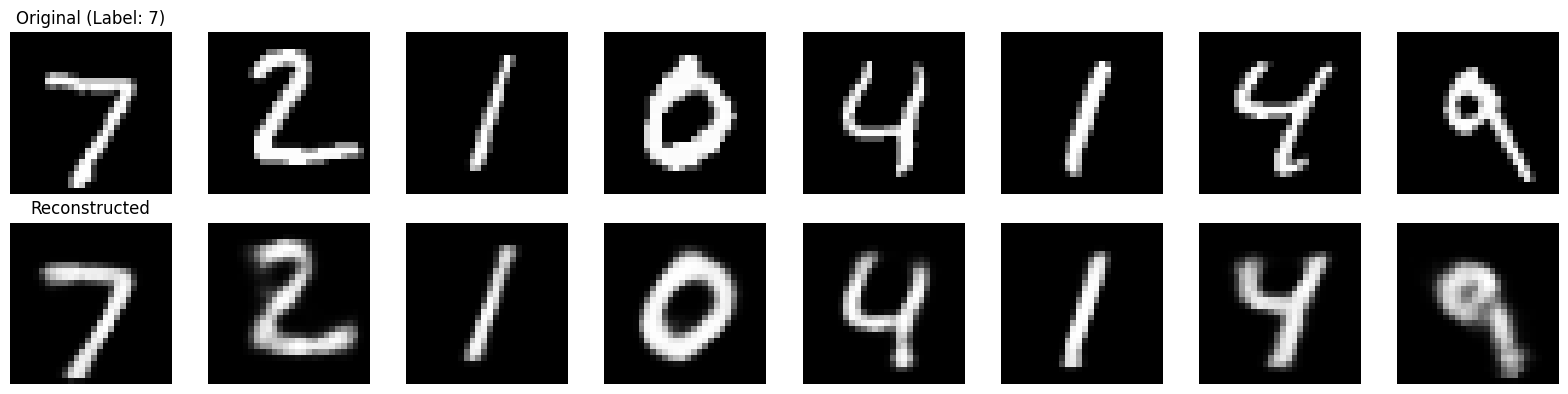

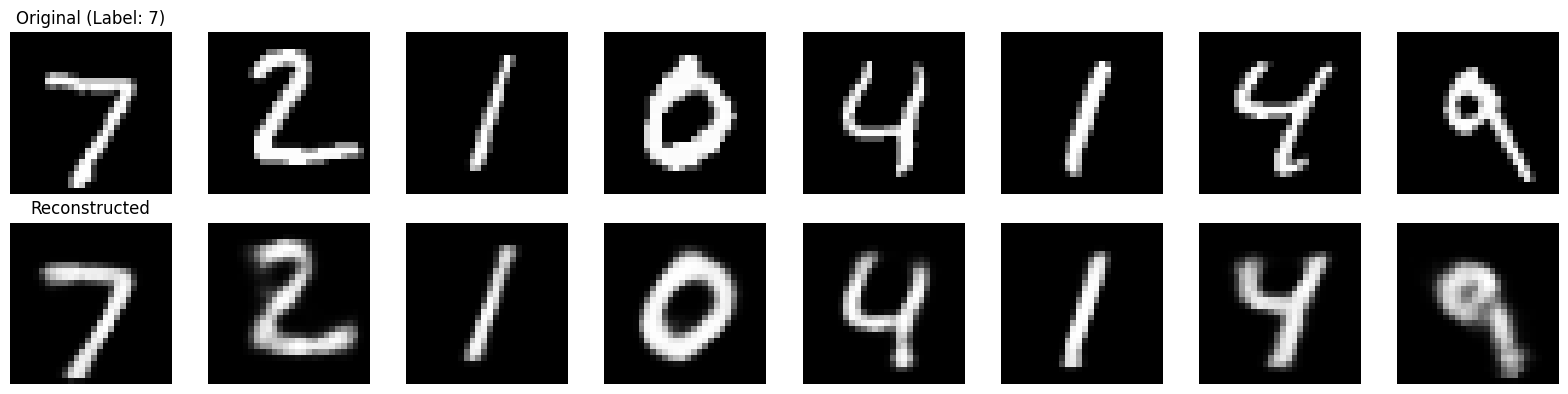

In [ ]:
# Load MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor()
])

test_dataset = datasets.MNIST('./data', train=False, download=True, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

visualize_conditional_reconstruction(model, test_loader, 'cpu', target_label=None, num_images=8)

# cvae mnist

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Define the CVAE class
class CVAE(nn.Module):
    def __init__(self, image_dim, state_dim, latent_dim):
        super(CVAE, self).__init__()
        self.image_dim = image_dim
        self.state_dim = state_dim
        self.latent_dim = latent_dim

        # Encoder: q(z | y, s)
        self.encoder = nn.Sequential(
            nn.Linear(image_dim + state_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
        )
        self.mu_layer = nn.Linear(128, latent_dim)  # Mean of q(z | y, s)
        self.log_var_layer = nn.Linear(128, latent_dim)  # Log-variance of q(z | y, s)

        # Decoder: p(y | z, s)
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim + state_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, image_dim),
            nn.Sigmoid()  # Output probabilities for binary images (e.g., MNIST)
        )

    def encode(self, y, s):
        """
        Encodes the observation y and state s into a latent distribution q(z | y, s).
        """
        inputs = torch.cat([y, s], dim=1)
        h = self.encoder(inputs)
        mu = self.mu_layer(h)
        log_var = self.log_var_layer(h)
        return mu, log_var

    def reparameterize(self, mu, log_var):
        """
        Reparameterization trick to sample from N(mu, sigma^2) using N(0, 1).
        """
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z, s):
        """
        Decodes latent variable z and state s into an image.
        """
        inputs = torch.cat([z, s], dim=1)
        return self.decoder(inputs)

    def forward(self, y, s):
        """
        Forward pass through the CVAE: y -> q(z | y, s) -> z -> p(y | z, s).
        """
        mu, log_var = self.encode(y, s)
        z = self.reparameterize(mu, log_var)
        recon_y = self.decode(z, s)
        return recon_y, mu, log_var

    def compute_loss(self, y, recon_y, mu, log_var):
        """
        Computes the ELBO loss for training the CVAE.
        """
        recon_loss = F.binary_cross_entropy(recon_y, y, reduction='sum')  # Reconstruction loss
        kl_divergence = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())  # KL divergence
        return recon_loss + kl_divergence

# Training the CVAE on MNIST
def train_cvae():
    # Hyperparameters
    batch_size = 64
    epochs = 10
    learning_rate = 1e-3

    # Data loaders
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x.view(-1))  # Flatten the image
    ])

    train_dataset = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    # Model, optimizer, and loss
    image_dim = 28 * 28  # For MNIST images
    state_dim = 10  # Example state dimension (dummy states)
    latent_dim = 20
    cvae = CVAE(image_dim, state_dim, latent_dim)
    optimizer = torch.optim.Adam(cvae.parameters(), lr=learning_rate)

    # Training loop
    for epoch in range(epochs):
        total_loss = 0
        for batch_idx, (images, _) in enumerate(train_loader):
            # Dummy state input (e.g., random noise for simplicity)
            batch_size = images.size(0)
            states = torch.rand(batch_size, state_dim)

            # Forward pass
            recon_images, mu, log_var = cvae(images, states)
            loss = cvae.compute_loss(images, recon_images, mu, log_var)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        print(f"Epoch [{epoch + 1}/{epochs}], Loss: {total_loss / len(train_loader.dataset):.4f}")
    return cvae

# Run training
if __name__ == "__main__":
    cvae = train_cvae()


Epoch [1/10], Loss: 173.0020
Epoch [2/10], Loss: 128.7268
Epoch [3/10], Loss: 120.5883
Epoch [4/10], Loss: 116.7430
Epoch [5/10], Loss: 113.8662
Epoch [6/10], Loss: 111.8306
Epoch [7/10], Loss: 110.3375
Epoch [8/10], Loss: 109.1425
Epoch [9/10], Loss: 108.1146
Epoch [10/10], Loss: 107.3804


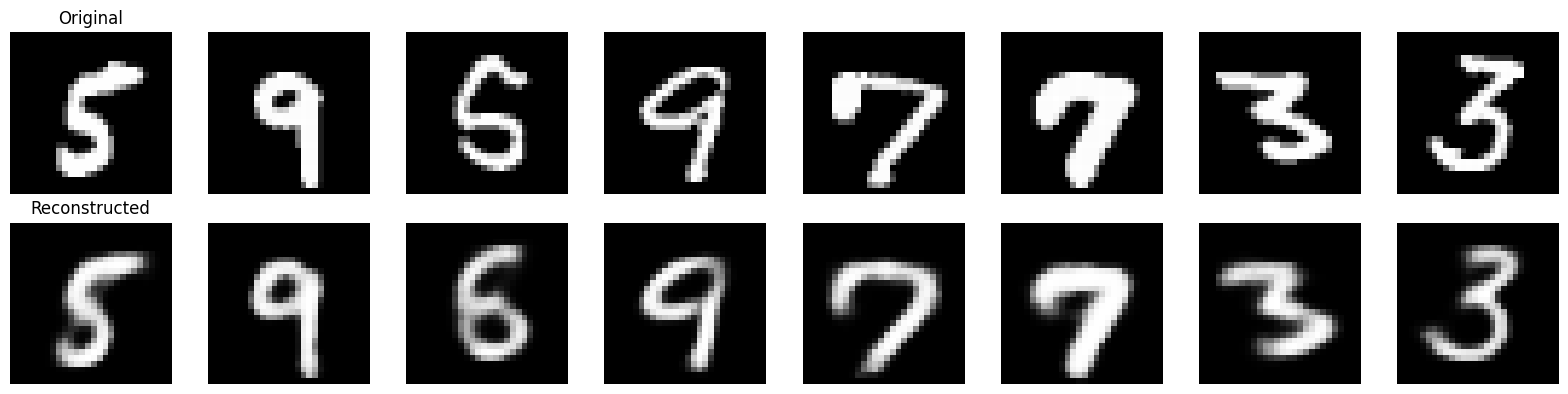

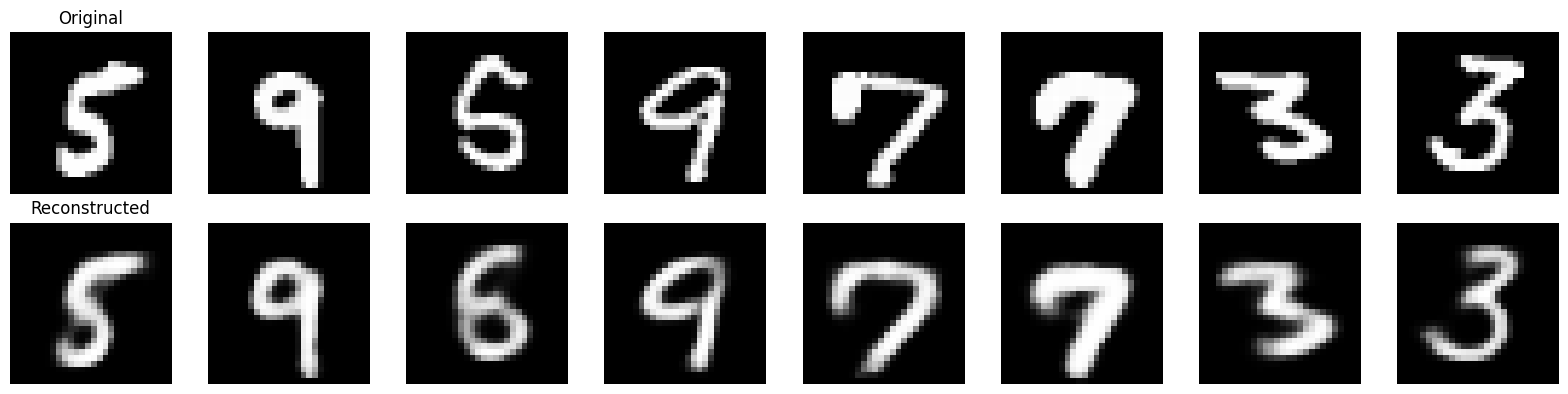

In [23]:
def cvae_visualize_reconstruction(model, data_loader, device, num_images=8):
    model.eval()
    with torch.no_grad():
        data = next(iter(data_loader))[0][:num_images].to(device)

        recon_batch, _, _ = model(data,torch.rand(8, 10).to(device))
        
        # Plot original and reconstructed images
        fig, axes = plt.subplots(2, num_images, figsize=(2*num_images, 4))
        
        for i in range(num_images):
            # Original images
            axes[0, i].imshow(data[i].cpu().numpy().reshape(28, 28), cmap='gray')
            axes[0, i].axis('off')
            if i == 0:
                axes[0, i].set_title('Original')
                
            # Reconstructed images
            axes[1, i].imshow(recon_batch[i].cpu().numpy().reshape(28, 28), cmap='gray')
            axes[1, i].axis('off')
            if i == 0:
                axes[1, i].set_title('Reconstructed')
        
        plt.tight_layout()
        return fig
    
# Load MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.view(-1))  # Flatten the image
])

test_dataset = datasets.MNIST('./data', train=False, download=True, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=True)

cvae_visualize_reconstruction(cvae, test_loader, 'cpu')


tensor(-94.0791, grad_fn=<MeanBackward0>)

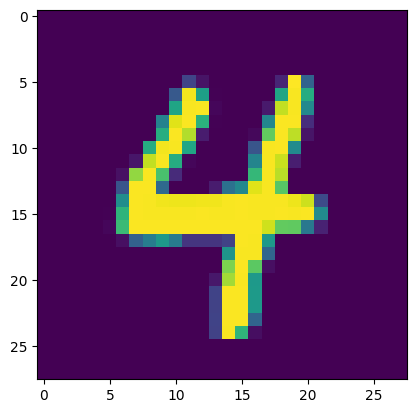

In [48]:
def evaluate_likelihood(cvae, y, s, num_samples=100):
    """
    Evaluates the likelihood p(y | s) using importance sampling.
    """
    mu, log_var = cvae.encode(y, s)
    std = torch.exp(0.5 * log_var)
    batch_size, latent_dim = mu.shape

    log_p_y_given_s = 0.0

    for _ in range(num_samples):
        z = cvae.reparameterize(mu, log_var)  # Sample z from q(z | y, s)
        recon_y = cvae.decode(z, s)  # Decode p(y | z, s)

        # Compute log-likelihood of y under the reconstruction
        log_p_y_given_z_s = -F.binary_cross_entropy(recon_y, y, reduction='none').sum(dim=1)

        # Compute log-likelihood of z under the prior
        log_p_z = -0.5 * (z.pow(2).sum(dim=1) + latent_dim * torch.log(torch.tensor(2 * torch.pi)))

        # Compute log-likelihood of z under the approximate posterior q(z | y, s)
        log_q_z_given_y_s = -0.5 * ((2 * std.log()).sum(dim=1) + ((z - mu).pow(2) / std.pow(2)).sum(dim=1) + latent_dim * torch.log(torch.tensor(2 * torch.pi)))

        # Combine terms for log-likelihood p(y | s)
        log_p_y_given_s += torch.exp(log_p_y_given_z_s + log_p_z - log_q_z_given_y_s)

    # Average over samples
    log_p_y_given_s = torch.log(log_p_y_given_s / num_samples)
    return log_p_y_given_s.mean()


# Load MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.view(-1))  # Flatten the image
])

test_dataset = datasets.MNIST('./data', train=False, download=True, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True)

# sample a random image and state
images = next(iter(test_loader))[0]

import matplotlib.pyplot as plt
plt.imshow(images[0].view(28, 28).numpy())

batch_size = images.shape[0]
state_dim = 10
states = torch.rand(batch_size, state_dim)

# Evaluate likelihood on test data
evaluate_likelihood(cvae, images, states, num_samples=100)


# any deform


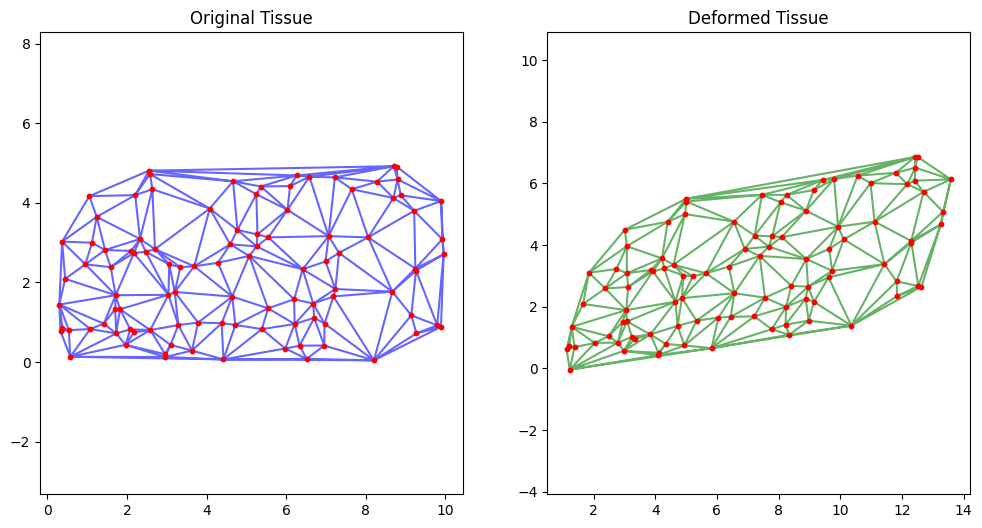

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import Delaunay

# Define a function to generate a 2D elastic tissue mesh
def generate_tissue(width, height, n_points):
    """Generate a random 2D mesh of elastic tissue."""
    x = np.random.uniform(0, width, n_points)
    y = np.random.uniform(0, height, n_points)
    points = np.vstack((x, y)).T
    tri = Delaunay(points)
    return points, tri

# Define a function to apply deformation to the mesh
def deform_tissue(points, tri, deformation_function):
    """Deform the 2D mesh based on a user-defined deformation function.

    Args:
        points (ndarray): Array of shape (n_points, 2) with x, y coordinates.
        tri (Delaunay): Triangulation of the points.
        deformation_function (callable): Function that maps (x, y) -> (x', y').

    Returns:
        deformed_points (ndarray): Array of deformed points.
    """
    deformed_points = np.array([deformation_function(p[0], p[1]) for p in points])
    return deformed_points

# Define a sample deformation function (e.g., stretching)
def sample_deformation(x, y):
    """Example deformation function: apply an affine transformation."""
    # Define an affine transformation matrix
    A = np.array([[1.2, 0.3],  # Stretch and shear in x
                  [0.2, 1.1]])  # Shear and stretch in y
    b = np.array([0.5, -0.3])  # Translation vector

    # Apply the transformation
    original_point = np.array([x, y])
    transformed_point = A @ original_point + b
    return transformed_point[0], transformed_point[1]

# Visualization of the tissue before and after deformation
def visualize_tissue(points, tri, deformed_points):
    """Visualize the tissue mesh before and after deformation."""
    plt.figure(figsize=(12, 6))

    # Original tissue
    plt.subplot(1, 2, 1)
    plt.triplot(points[:, 0], points[:, 1], tri.simplices, color='blue', alpha=0.6)
    plt.scatter(points[:, 0], points[:, 1], color='red', s=10)
    plt.title("Original Tissue")
    plt.axis("equal")

    # Deformed tissue
    plt.subplot(1, 2, 2)
    plt.triplot(deformed_points[:, 0], deformed_points[:, 1], tri.simplices, color='green', alpha=0.6)
    plt.scatter(deformed_points[:, 0], deformed_points[:, 1], color='red', s=10)
    plt.title("Deformed Tissue")
    plt.axis("equal")

    plt.show()

# Main workflow
if __name__ == "__main__":
    # Generate a 2D elastic tissue
    width, height = 10, 5
    n_points = 100
    points, tri = generate_tissue(width, height, n_points)

    # Apply deformation
    deformed_points = deform_tissue(points, tri, sample_deformation)

    # Visualize the results
    visualize_tissue(points, tri, deformed_points)


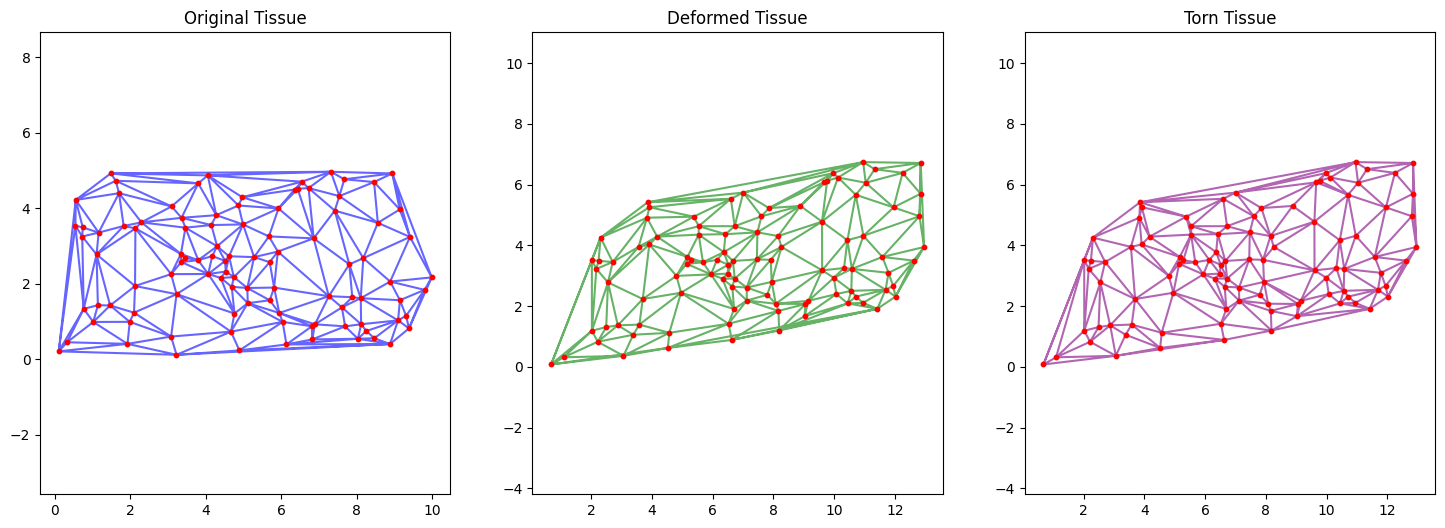

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import Delaunay

# Define a function to generate a 2D elastic tissue mesh
def generate_tissue(width, height, n_points):
    """Generate a random 2D mesh of elastic tissue."""
    x = np.random.uniform(0, width, n_points)
    y = np.random.uniform(0, height, n_points)
    points = np.vstack((x, y)).T
    tri = Delaunay(points)
    return points, tri

# Define a function to apply deformation to the mesh
def deform_tissue(points, tri, deformation_function):
    """Deform the 2D mesh based on a user-defined deformation function.

    Args:
        points (ndarray): Array of shape (n_points, 2) with x, y coordinates.
        tri (Delaunay): Triangulation of the points.
        deformation_function (callable): Function that maps (x, y) -> (x', y').

    Returns:
        deformed_points (ndarray): Array of deformed points.
    """
    deformed_points = np.array([deformation_function(p[0], p[1]) for p in points])
    return deformed_points

# Define a sample deformation function (e.g., general affine and nonlinear transformations)
def sample_deformation(x, y):
    """Example deformation function: apply both affine and nonlinear transformations."""
    # Affine transformation
    A = np.array([[1.2, 0.3],  # Stretch and shear in x
                  [0.2, 1.1]])  # Shear and stretch in y
    b = np.array([0.5, -0.3])  # Translation vector

    original_point = np.array([x, y])
    affine_transformed = A @ original_point + b

    # Nonlinear deformation (e.g., sinusoidal warping)
    nonlinear_x = affine_transformed[0] + 0.2 * np.sin(2 * np.pi * affine_transformed[1] / 5)
    nonlinear_y = affine_transformed[1] + 0.2 * np.cos(2 * np.pi * affine_transformed[0] / 5)

    return nonlinear_x, nonlinear_y

# Define a function to simulate tearing
def simulate_tearing(points, tri, threshold=1.5):
    """Simulate tearing by removing edges that exceed a deformation threshold.

    Args:
        points (ndarray): Array of original points.
        tri (Delaunay): Triangulation of the points.
        threshold (float): Maximum allowable distance for an edge before tearing occurs.

    Returns:
        new_tri (Delaunay): Updated triangulation after tearing.
    """
    edges = []
    for simplex in tri.simplices:
        for i in range(3):
            p1, p2 = points[simplex[i]], points[simplex[(i + 1) % 3]]
            if np.linalg.norm(p1 - p2) <= threshold:
                edges.append((simplex[i], simplex[(i + 1) % 3]))

    # Create a new triangulation from the remaining edges
    unique_edges = np.unique(edges)
    new_points = points[unique_edges]
    new_tri = Delaunay(new_points)
    return new_points, new_tri

# Visualization of the tissue before and after deformation/tearing
def visualize_tissue(points, tri, deformed_points, torn_points=None, torn_tri=None):
    """Visualize the tissue mesh before and after deformation or tearing."""
    plt.figure(figsize=(18, 6))

    # Original tissue
    plt.subplot(1, 3, 1)
    plt.triplot(points[:, 0], points[:, 1], tri.simplices, color='blue', alpha=0.6)
    plt.scatter(points[:, 0], points[:, 1], color='red', s=10)
    plt.title("Original Tissue")
    plt.axis("equal")

    # Deformed tissue
    plt.subplot(1, 3, 2)
    plt.triplot(deformed_points[:, 0], deformed_points[:, 1], tri.simplices, color='green', alpha=0.6)
    plt.scatter(deformed_points[:, 0], deformed_points[:, 1], color='red', s=10)
    plt.title("Deformed Tissue")
    plt.axis("equal")

    # Torn tissue
    if torn_points is not None and torn_tri is not None:
        plt.subplot(1, 3, 3)
        plt.triplot(torn_points[:, 0], torn_points[:, 1], torn_tri.simplices, color='purple', alpha=0.6)
        plt.scatter(torn_points[:, 0], torn_points[:, 1], color='red', s=10)
        plt.title("Torn Tissue")
        plt.axis("equal")

    plt.show()

# Main workflow
if __name__ == "__main__":
    # Generate a 2D elastic tissue
    width, height = 10, 5
    n_points = 100
    points, tri = generate_tissue(width, height, n_points)

    # Apply deformation
    deformed_points = deform_tissue(points, tri, sample_deformation)

    # Simulate tearing
    torn_points, torn_tri = simulate_tearing(deformed_points, tri)

    # Visualize the results
    visualize_tissue(points, tri, deformed_points, torn_points, torn_tri)


In [ ]:
np.all(deformed_points == torn_points)

True

In [54]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from tqdm import tqdm

# Define the PixelCNN class
class PixelCNN(nn.Module):
    def __init__(self, input_dim, num_classes, hidden_channels=64):
        super(PixelCNN, self).__init__()

        self.input_dim = input_dim
        self.num_classes = num_classes

        # Gated convolutional layers
        self.conv1 = nn.Conv2d(num_classes, hidden_channels, kernel_size=7, padding=3)
        self.conv2 = nn.Conv2d(hidden_channels, hidden_channels, kernel_size=7, padding=3)
        self.conv3 = nn.Conv2d(hidden_channels, hidden_channels, kernel_size=7, padding=3)
        self.conv4 = nn.Conv2d(hidden_channels, num_classes, kernel_size=1)  # Final output layer

    def forward(self, x):
        """
        Forward pass through the PixelCNN model.
        """
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = self.conv4(x)  # Output logits for each pixel
        return x

# Helper to one-hot encode the input
def one_hot_encode(images, num_classes):
    batch_size, height, width = images.size()
    one_hot = torch.zeros(batch_size, num_classes, height, width, device=images.device)
    one_hot.scatter_(1, images.unsqueeze(1), 1)
    return one_hot

# Training the PixelCNN on MNIST
def train_pixelcnn():
    # Hyperparameters
    batch_size = 64
    epochs = 10
    learning_rate = 1e-3
    num_classes = 256  # Pixel intensity levels

    # Data loaders
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Lambda(lambda x: (x * 255).long())  # Scale to [0, 255] and convert to int
    ])

    train_dataset = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    
    # Device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Model, optimizer, and loss
    input_dim = (28, 28)  # MNIST image dimensions
    pixelcnn = PixelCNN(input_dim, num_classes).to(device)
    optimizer = torch.optim.Adam(pixelcnn.parameters(), lr=learning_rate)

    # Training loop
    for epoch in range(epochs):
        total_loss = 0
        for batch_idx, (images, _) in tqdm(enumerate(train_loader),total=len(train_loader)):
            images = images.squeeze(1)  # Remove channel dimension
            one_hot_images = one_hot_encode(images, num_classes)

            # Forward pass
            logits = pixelcnn(one_hot_images.to(device))

            # Compute loss (cross-entropy)
            loss = F.cross_entropy(logits, images)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        print(f"Epoch [{epoch + 1}/{epochs}], Loss: {total_loss / len(train_loader.dataset):.4f}")

    return pixelcnn
# Computing likelihood of an observation
def compute_likelihood(pixelcnn, image):
    """
    Computes the likelihood of an image under the trained PixelCNN model.
    """
    image = image.unsqueeze(0).long()  # Add batch dimension and convert to int
    one_hot_image = one_hot_encode(image, pixelcnn.num_classes)

    with torch.no_grad():
        logits = pixelcnn(one_hot_image)
        probs = F.softmax(logits, dim=1)

    # Compute likelihood as the product of probabilities
    likelihood = torch.gather(probs, 1, image.unsqueeze(1)).squeeze(1)
    log_likelihood = likelihood.log().sum()

    return log_likelihood.item()

# Run training
if __name__ == "__main__":
    pixelcnn = train_pixelcnn()


RuntimeError: CUDA error: CUDA-capable device(s) is/are busy or unavailable
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


# cvae tissue manipulation

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms

class ConditionalVAE(nn.Module):
    def __init__(self, latent_dim=128, condition_dim=4):
        super(ConditionalVAE, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
        )
        
        # Calculate the size of flattened features
        self.flatten_size = 512 * 16 * 32
        
        # Condition embedding
        self.condition_encoder = nn.Sequential(
            nn.Linear(condition_dim, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU()
        )
        
        # Mu and logvar layers
        self.fc_mu = nn.Linear(self.flatten_size + 1024, latent_dim)
        self.fc_logvar = nn.Linear(self.flatten_size + 1024, latent_dim)
        
        # Decoder input
        self.decoder_input = nn.Linear(latent_dim + condition_dim, self.flatten_size)
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            
            nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid()
        )
        
    def encode(self, x, c):
        # Encode the input image
        x = self.encoder(x)
        x = x.view(x.size(0), -1)  # Flatten
        
        # Encode the condition
        c = self.condition_encoder(c)
        
        # Concatenate image features and condition
        x = torch.cat([x, c], dim=1)
        
        # Get mu and logvar
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        
        return mu, logvar
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def decode(self, z, c):
        # Concatenate latent vector and condition
        z = torch.cat([z, c], dim=1)
        
        # Pass through decoder input layer
        x = self.decoder_input(z)
        
        # Reshape to match decoder input dimensions
        x = x.view(x.size(0), 512, 16, 32)
        
        # Decode
        x = self.decoder(x)
        return x
    
    def forward(self, x, c):
        mu, logvar = self.encode(x, c)
        z = self.reparameterize(mu, logvar)
        return self.decode(z, c), mu, logvar

def vae_loss(recon_x, x, mu, logvar, beta=1.0):
    """
    Calculate the VAE loss with KL divergence
    """
    # Reconstruction loss (binary cross entropy)
    # BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')
    MSE = F.mse_loss(recon_x, x, reduction='sum')

    # KL divergence
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    
    return MSE + beta * KLD

def train_cvae():
    # Hyperparameters
    batch_size = 2
    epochs = 1
    learning_rate = 1e-3
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    

    # Data loaders
    # transform = transforms.Compose([
    #     transforms.ToTensor(),  # If images aren't already tensors
    #     transforms.Normalize(mean=[0.5, 0.5, 0.5], 
    #                         std=[0.5, 0.5, 0.5])
    # ])

    import numpy as np
    images = np.load('dataset/images_upto_999.npy')
    actions = np.load('dataset/actions_upto_999.npy')

    from torch.utils.data import Dataset, DataLoader
    class CustomDataset(Dataset):
        def __init__(self, images, actions, transforms=None):
            """
            Args:
                data_list (list): List of dictionaries containing 'o', 'theta', 'qpos', and 'qpos_new'.
            """
            assert len(images) == len(actions), "Number of images and actions must match."

            self.observations = images
            self.latent = actions
            self.transforms = transforms

        def __len__(self):
            """Returns the total number of samples."""
            return len(self.observations)

        def __getitem__(self, idx):
            """
            Retrieve one sample of data by index.

            Args:
                idx (int): Index of the sample to retrieve.

            Returns:
                A dictionary with inputs and expected outputs as tensors.
            """
            # Extract the dictionary for the given index
            image = self.observations[idx]
            action = self.latent[idx]
            
            # Convert data to PyTorch tensors
            theta = torch.tensor(action, dtype=torch.float32)
            o = torch.tensor(image, dtype=torch.float32).permute(2, 0, 1)
            # pos = è costante in questo caso      

            # Inputs: qpos_new, o, theta
            inputs = {
                'theta': theta,
                'deform_obs': o    
            }
            
            # Output: qpos_new
            target = {
                'theta': theta,
                'deform_obs': o    
            }
            
            return inputs, target

    # Instantiate the dataset
    custom_dataset = CustomDataset(images, actions)

    # Create a DataLoader
    train_loader = DataLoader(custom_dataset, batch_size, shuffle=True)

    # Model, optimizer, and loss
    model = ConditionalVAE()
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    from tqdm.notebook import tqdm    # Training loop
    
    for epoch in range(epochs):
        total_loss = 0
        for batch_idx, (images, _) in tqdm(enumerate(train_loader), total=len(train_loader)):
            # Dummy state input (e.g., random noise for simplicity)
            recon_images, mu, log_var = model(images['deform_obs'].to(device), images['theta'].to(device))
            loss = vae_loss(recon_images, images['deform_obs'].to(device), mu, log_var)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        print(f"Epoch [{epoch + 1}/{epochs}], Loss: {total_loss / len(train_loader.dataset):.4f}")
    
    return model

# Run training
if __name__ == "__main__":
    model = train_cvae()


In [5]:
import numpy as np
images = np.load('dataset/images_upto_999.npy')
actions = np.load('dataset/actions_upto_999.npy')

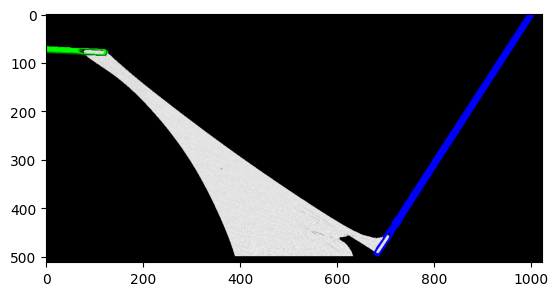

In [86]:
import matplotlib.pyplot as plt 
plt.imshow(images[np.random.randint(0, 999)])

In [107]:
from torch.utils.data import Dataset, DataLoader

class CustomDataset(Dataset):
    def __init__(self, images, actions):
        """
        Args:
            data_list (list): List of dictionaries containing 'o', 'theta', 'qpos', and 'qpos_new'.
        """
        assert len(images) == len(actions), "Number of images and actions must match."

        self.observations = images
        self.latent = actions

    def __len__(self):
        """Returns the total number of samples."""
        return len(self.observations)

    def __getitem__(self, idx):
        """
        Retrieve one sample of data by index.

        Args:
            idx (int): Index of the sample to retrieve.

        Returns:
            A dictionary with inputs and expected outputs as tensors.
        """
        # Extract the dictionary for the given index
        image = self.observations[idx]
        action = self.latent[idx]
        
        # Convert data to PyTorch tensors
        theta = torch.tensor(action, dtype=torch.float32)
        o = torch.tensor(image, dtype=torch.float32).permute(2, 0, 1)
        # pos = è costante in questo caso      
        

        # Inputs: qpos_new, o, theta
        inputs = {
            'theta': theta,
            'deform_obs': o    
        }
        
        # Output: qpos_new
        target = {
            'theta': theta,
            'deform_obs': o    
        }
        
        return inputs, target


# Instantiate the dataset
custom_dataset = CustomDataset(images, actions)

# Create a DataLoader
data_loader = DataLoader(custom_dataset, batch_size=10, shuffle=True)

# Visualize a batch of data
for inputs, targets in data_loader:
    print(f"Inputs: {inputs['deform_obs'].shape}, {inputs['theta'].shape}")
    print(f"Targets: {targets['deform_obs'].shape}, {targets['theta'].shape}")
    break

Inputs: torch.Size([10, 3, 512, 1024]), torch.Size([10, 4])
Targets: torch.Size([10, 3, 512, 1024]), torch.Size([10, 4])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


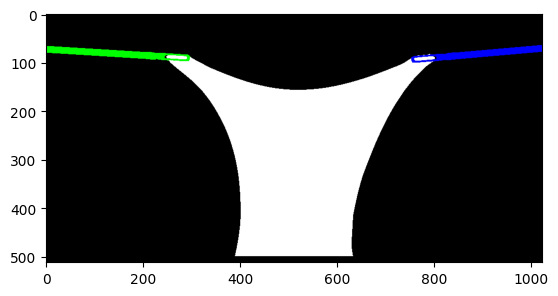

In [16]:
import matplotlib.pyplot as plt
plt.imshow(inputs['deform_obs'][0])

In [137]:
model = ConditionalVAE()
for _, (images, _) in enumerate(data_loader):
    recon_images, mu, log_var = model(images['deform_obs'], images['theta'])
    break

In [139]:
recon_images

tensor([[[[0.4818, 0.4764, 0.4907,  ..., 0.4760, 0.4756, 0.5080],
          [0.5334, 0.5985, 0.5718,  ..., 0.5203, 0.5757, 0.5405],
          [0.5415, 0.4911, 0.5827,  ..., 0.4504, 0.5505, 0.5477],
          ...,
          [0.5323, 0.6618, 0.5483,  ..., 0.5500, 0.5817, 0.5047],
          [0.5573, 0.4145, 0.6216,  ..., 0.4404, 0.5652, 0.5364],
          [0.5574, 0.5587, 0.5275,  ..., 0.5257, 0.5561, 0.5053]],

         [[0.4862, 0.5921, 0.4825,  ..., 0.6105, 0.4581, 0.5552],
          [0.4465, 0.5579, 0.4090,  ..., 0.5290, 0.4969, 0.4849],
          [0.4047, 0.4945, 0.3698,  ..., 0.5744, 0.3904, 0.5269],
          ...,
          [0.4369, 0.5455, 0.4194,  ..., 0.5492, 0.4382, 0.5246],
          [0.3799, 0.6611, 0.3674,  ..., 0.5734, 0.4238, 0.5124],
          [0.4849, 0.5125, 0.4393,  ..., 0.4934, 0.4640, 0.4929]],

         [[0.4631, 0.5079, 0.4666,  ..., 0.4715, 0.4278, 0.5512],
          [0.4774, 0.5267, 0.5056,  ..., 0.5175, 0.5095, 0.4759],
          [0.4807, 0.4871, 0.5429,  ..., 0